# Analysis of Chinese Water Quality


## Objective

Study and model the quality of Chinese water in order to explain and predict a pollution index based on geographical characteristics and the chemical composition of the analyzed waters.

In [2]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

In [3]:
#Split the dataset into 90% training set and 10% test set
csv_path = 'dataset.csv'
df = pd.read_csv(csv_path)
df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # errors='ignore' prevents an error if the column does not exist
RANDOM_STATE = 42
# Random 90%/10% split
train_df, val_df = train_test_split(df, test_size=0.10, random_state=RANDOM_STATE)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f'Total rows: {len(df)} ; Train: {len(train_df)} ({len(train_df)/len(df):.2%}) ; Test: {len(val_df)} ({len(val_df)/len(df):.2%})')

Total rows: 3000 ; Train: 2700 (90.00%) ; Test: 300 (10.00%)


## Descriptive Analysis of the Variables

---- Checking for missing values ----
No missing values detected in the training set.
Detected duplicates: 0
---- Checking for types and suspicious values ----
No object columns with partially numeric values detected.
Dataset cleaned

Descriptive statistics table (after cleaning):


,mean,sd,skewness,kurtosis
Water_Temperature_C,19.9880,4.9218,0.0224,-0.0312
pH,7.2079,0.5970,0.1994,-0.0897
Dissolved_Oxygen_mg_L,7.9947,1.9759,0.0133,-0.1442
Conductivity_uS_cm,509.5211,104.8794,0.0223,0.1503
Turbidity_NTU,5.0597,5.0686,2.0979,7.5884
Nitrate_mg_L,2.0279,0.5317,0.0970,0.0071
Nitrite_mg_L,0.0210,0.0097,0.1739,-0.2466
Ammonia_N_mg_L,0.5181,0.2059,0.1092,-0.2601
Total_Phosphorus_mg_L,0.1066,0.0487,0.1654,-0.3754
Total_Nitrogen_mg_L,3.0931,0.5249,0.1470,0.0633


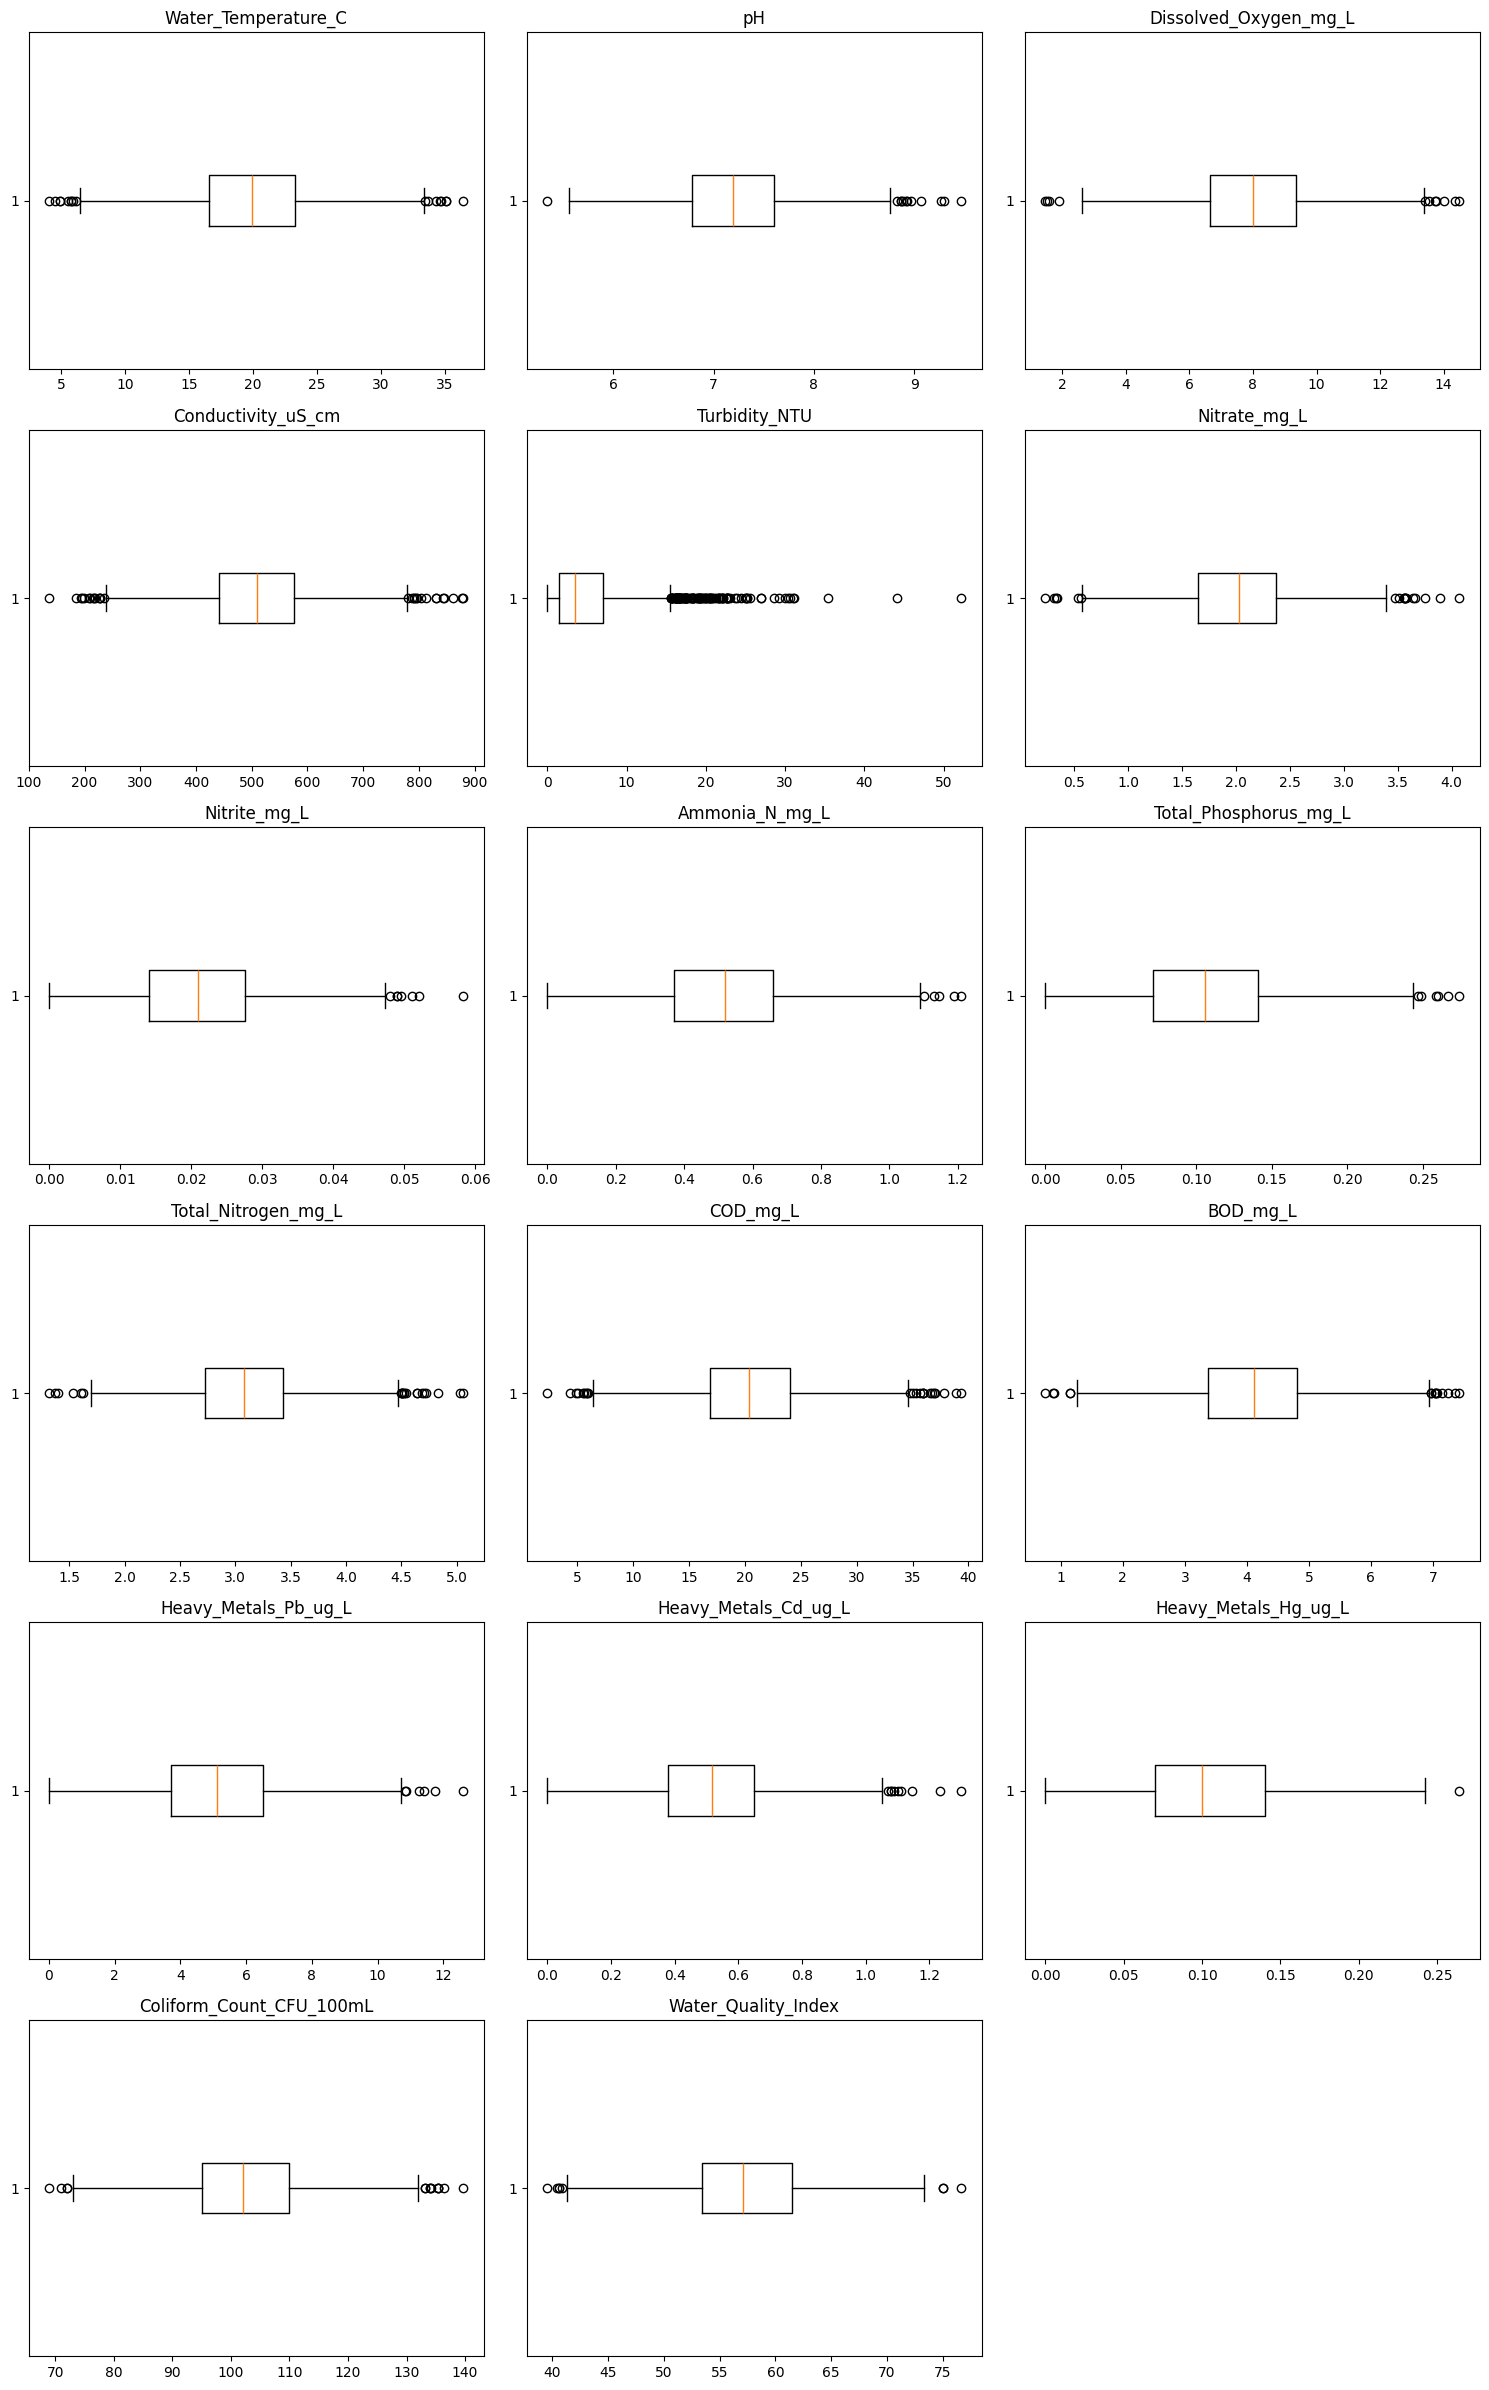

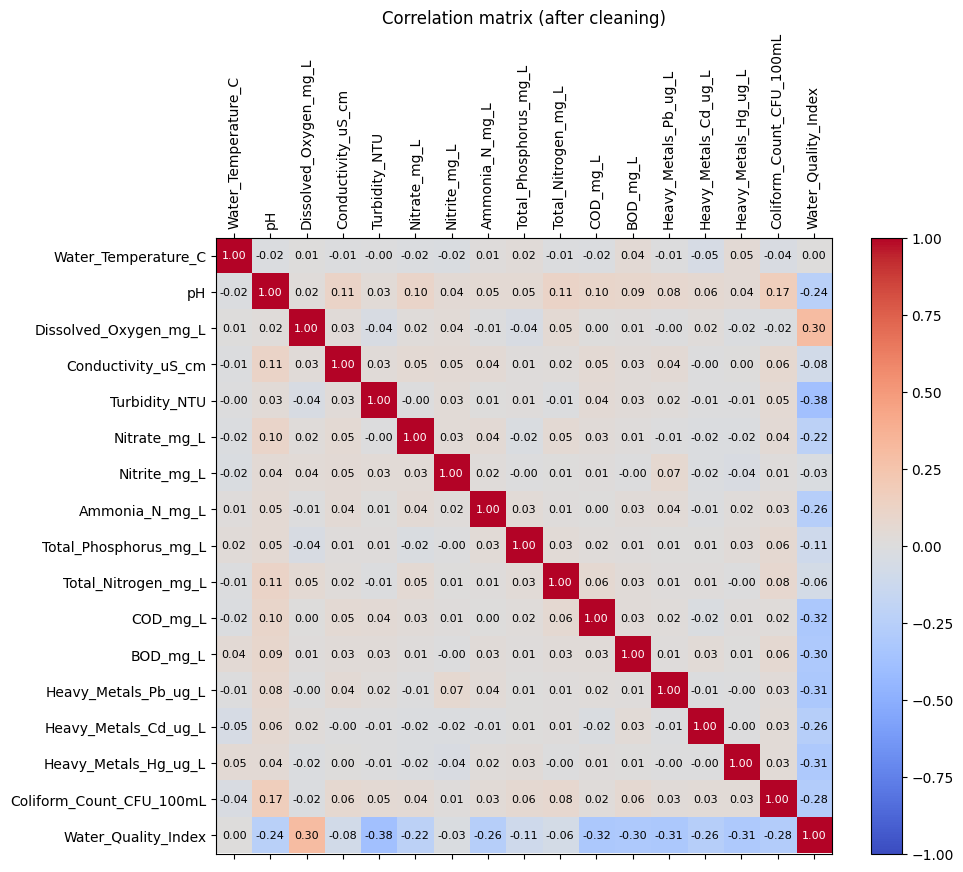

In [4]:
# Checks: Missing Values + Inconsistencies + Descriptive Statistics

# Missing values
print("---- Checking for missing values ----")
missing_counts = train_df.isnull().sum()
missing_perc = (train_df.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({'missing_count': missing_counts, 'missing_%': missing_perc})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_%', ascending=False)
if missing_df.empty:
    print("No missing values detected in the training set.")
else:
    display(missing_df)
    print("Examples of observations with at least one missing value:")
    display(train_df[train_df.isnull().any(axis=1)].head())

# Duplicates
dup = train_df.duplicated().sum()
print(f"Detected duplicates: {dup}")
if dup > 0:
    print("Examples of duplicate rows:")
    display(train_df[train_df.duplicated(keep=False)].head())

# Type / suspicious values (object columns partially containing numeric values)
print("---- Checking for types and suspicious values ----")
obj_cols = train_df.select_dtypes(include=['object']).columns.tolist()
suspect_cols = {}
for col in obj_cols:
    coerced = pd.to_numeric(train_df[col], errors='coerce')
    n_numeric = coerced.notna().sum()
    if 0 < n_numeric < len(train_df):
        suspect_cols[col] = f"{n_numeric}/{len(train_df)} convertible to numeric"
if suspect_cols:
    print("Object-type columns partially containing numeric values:")
    for k, v in suspect_cols.items():
        print(f" - {k}: {v}")
else:
    print("No object columns with partially numeric values detected.")

# Outlier checks
ranges = {
    'pH': (0, 14),
    'Turbidity_NTU': (0, None),
    'Water_Temperature_C': (-20, 50),
    'Water_Quality_Index': (0, None)
}
for col, (low, high) in ranges.items():
    if col in train_df.columns:
        s = train_df[col]
        mask = pd.Series(False, index=s.index)
        if low is not None:
            mask = mask | (s < low)
        if high is not None:
            mask = mask | (s > high)
        nviol = int(mask.sum())
        if nviol > 0:
            print(f"{nviol} out-of-range values detected for {col} (expected {low} to {high}). Examples:")
            display(train_df.loc[mask, [col]].head())

# === All-in-one: detect, display, clean, and analyze ===
concentration_cols = [c for c in train_df.columns if any(x in c for x in ['mg_L', 'ug_L', 'CFU', 'Count', 'Concentration'])]
# Force numeric conversion to ensure correct detection
for c in concentration_cols:
    train_df[c] = pd.to_numeric(train_df[c], errors='coerce')

# Count negatives per column
neg_counts = {c: int((train_df[c] < 0).sum()) for c in concentration_cols}

# Rows with at least one negative value
mask_neg_row = pd.DataFrame({c: train_df[c] < 0 for c in concentration_cols}).any(axis=1) if concentration_cols else pd.Series(False, index=train_df.index)
rows_with_neg = int(mask_neg_row.sum())

# Cleaning: remove rows containing negatives
n_before = len(train_df)
train_df = train_df.loc[~mask_neg_row].reset_index(drop=True)
print("Dataset cleaned")

# Descriptive analysis on cleaned df
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
stats_table = pd.DataFrame({
    'mean': train_df[num_cols].mean(),
    'sd': train_df[num_cols].std(),
    'skewness': train_df[num_cols].skew(),
    'kurtosis': train_df[num_cols].kurt()
}).round(4)

print('\nDescriptive statistics table (after cleaning):')
display(stats_table)

# Boxplots
cols = num_cols
n = len(cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
plt.figure(figsize=(5 * ncols, 4 * max(1, nrows)))
for i, c in enumerate(cols, 1):
    plt.subplot(nrows, ncols, i)
    plt.boxplot(train_df[c].dropna(), vert=False)
    plt.title(c)
plt.tight_layout()
plt.show()

# Correlation matrix
corr = train_df[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black', fontsize=8)
plt.title('Correlation matrix (after cleaning)')
plt.show()


## Model Selection and Assumption Checking
Select an adequate model for the response variable by considering all
 quantitative and qualitative variables and by using our model selec
tion strategies. Consider also possible interactions of the qualitative
 variables with one or several quantitative variables. Verify the under
lying hypotheses and, if necessary, take remedial actions. For example,
 check for : 
  (a) nonlinearity
 (b) outliers and/or influential observations,
 (c) multicollinearity,
 (d) heteroskedasticty, and
 (e) autocorrelation.

# +

 ## Test for significance of the estimated coefficients 
Test for significance of the estimated coefficients of the obtained model,
and interpret their signs. Give a more detailed interpretation of the
coefficients of the qualitative variables.

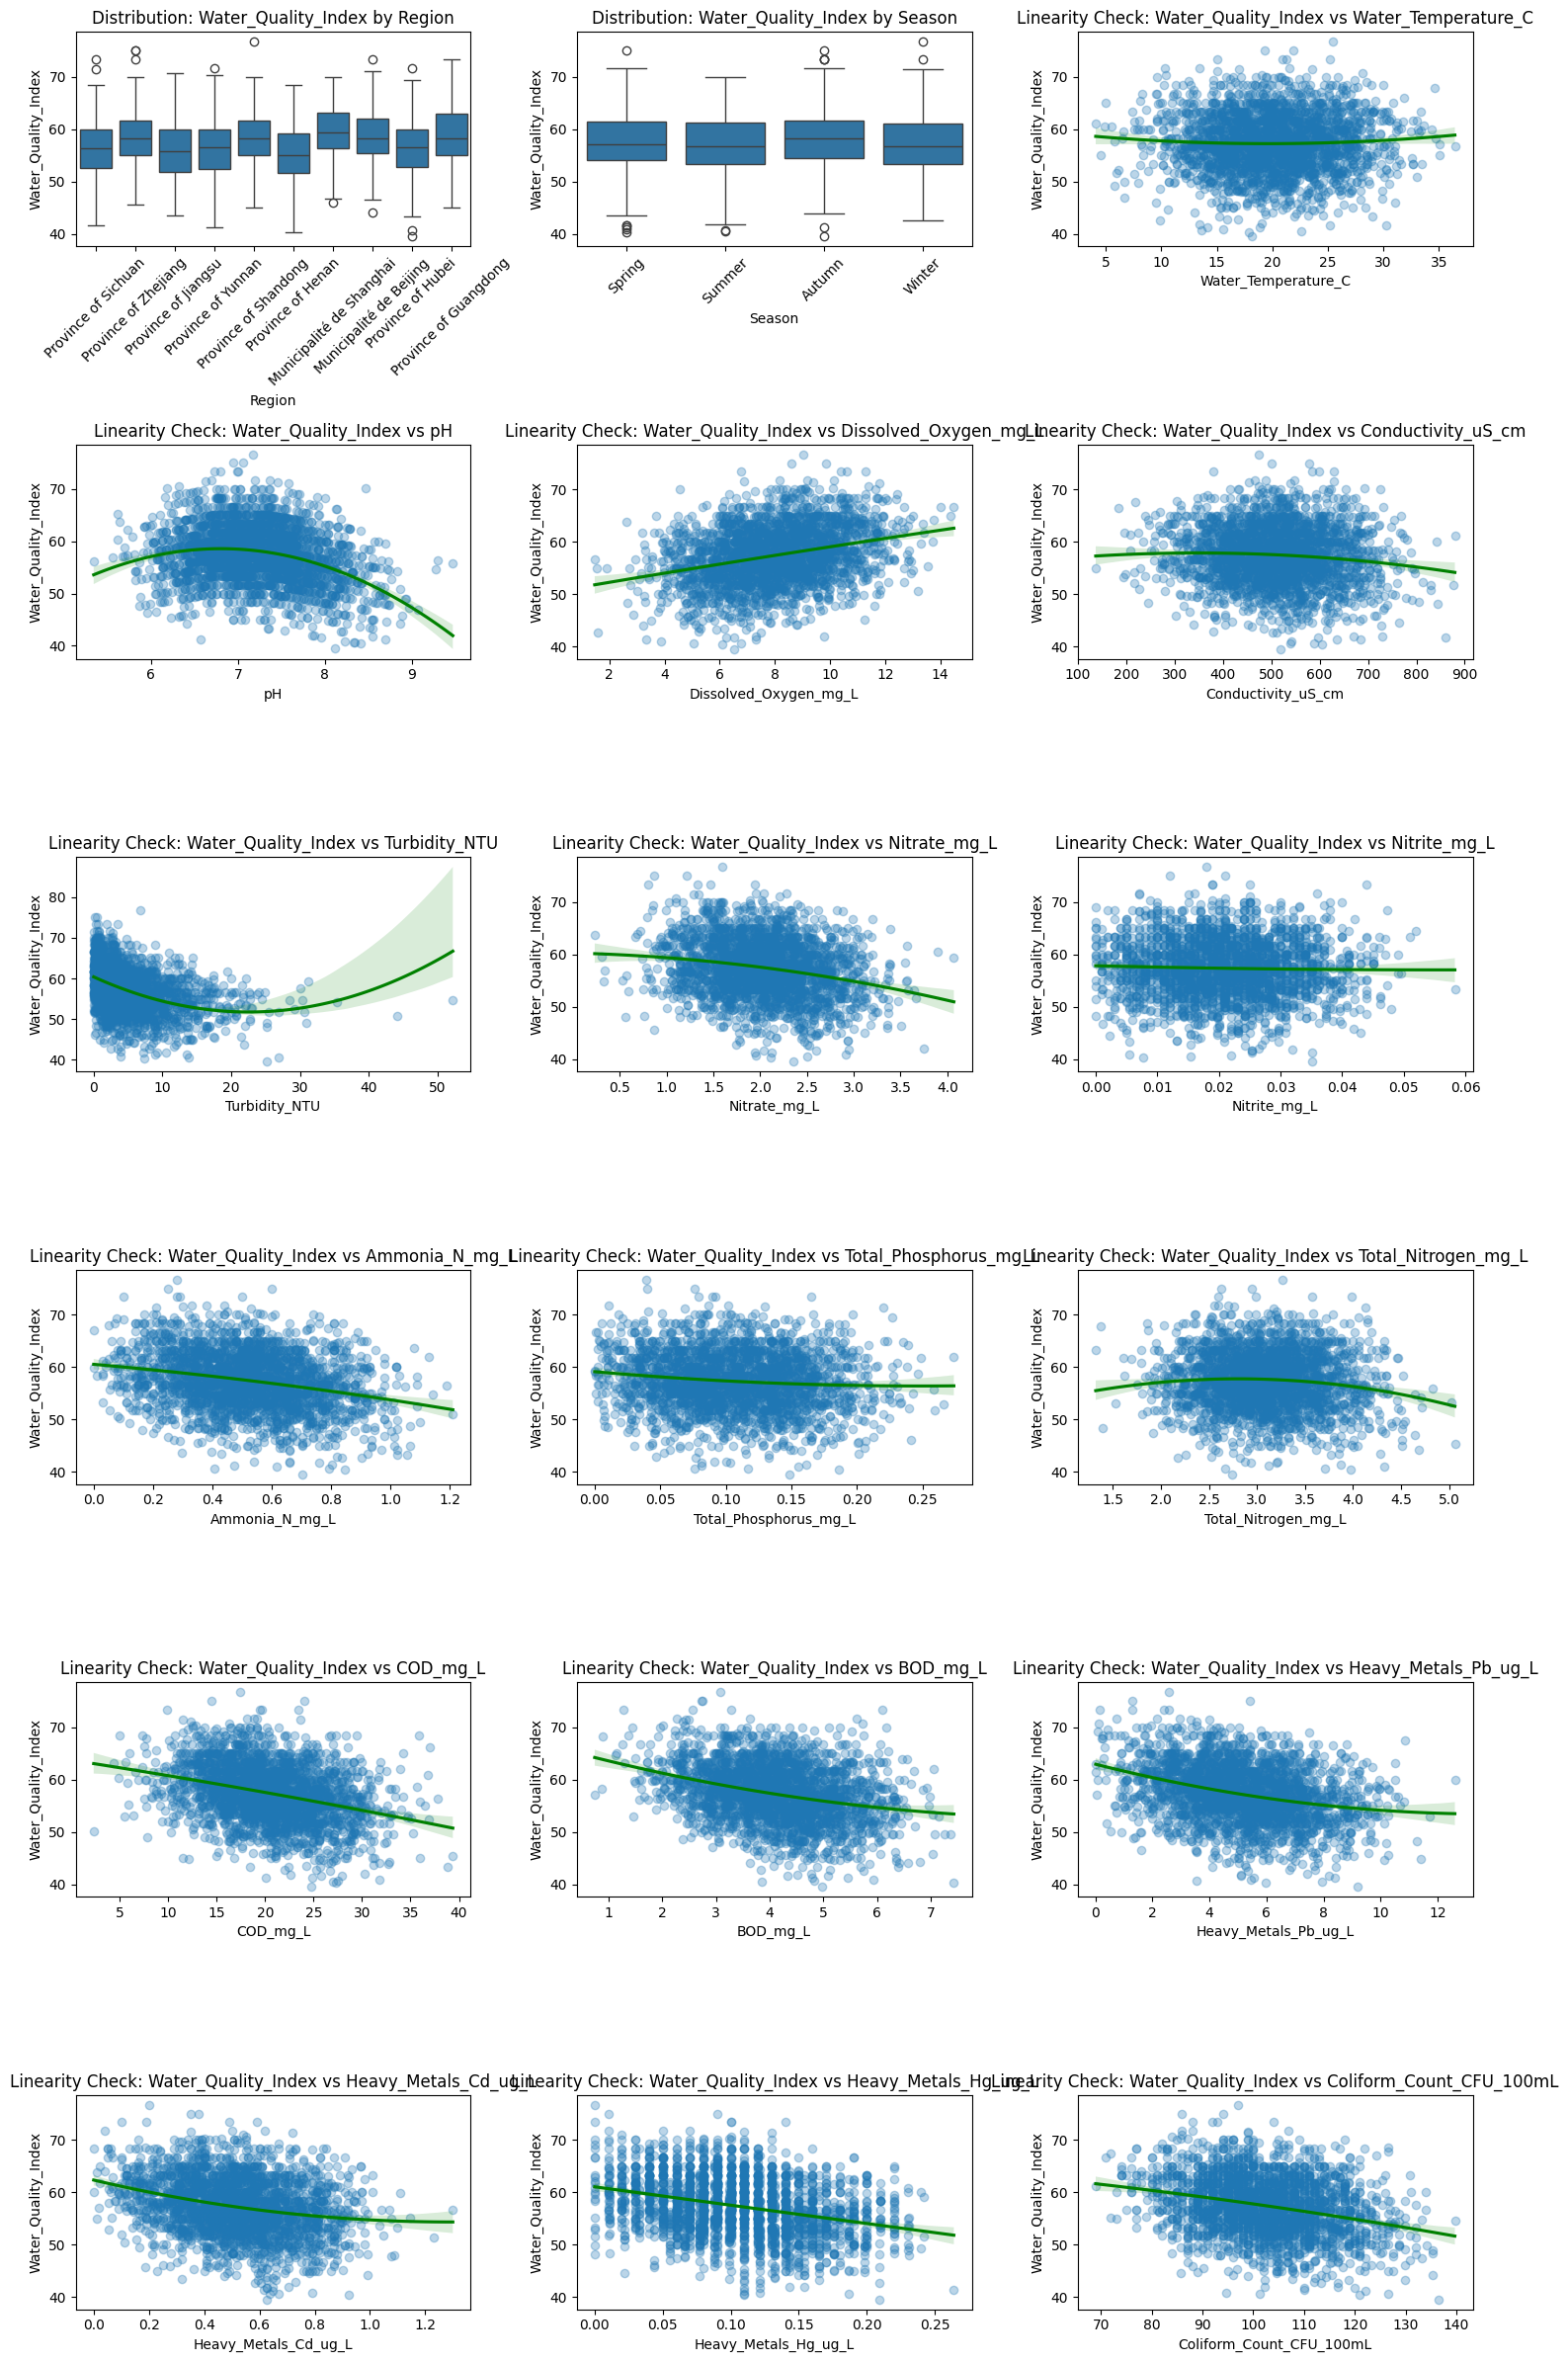

In [5]:
def pairwiseplot_for_linearity(df, y_var):
    # Get all columns except the target (y_var)
    x_vars = [col for col in df.columns if col != y_var and col is not None]
    
    n = len(x_vars)
    ncols = 3  
    nrows = (n + ncols - 1) // ncols 
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten() if n > 1 else [axes]  
    
    for i, x_var in enumerate(x_vars):
        ax = axes[i]
        
        # Numeric x
        if pd.api.types.is_numeric_dtype(df[x_var]):
            sns.regplot(data=df, x=x_var, y=y_var, 
                        order=2,  # quadratic trend line
                        scatter_kws={'alpha': 0.3}, 
                        line_kws={'color': 'green'},
                        ax=ax)
            ax.set_title(f"Linearity Check: {y_var} vs {x_var}")
            
        # Categorical x
        else:
            sns.boxplot(data=df, x=x_var, y=y_var, ax=ax)
            ax.set_title(f"Distribution: {y_var} by {x_var}")
            ax.tick_params(axis='x', rotation=45)
        
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
pairwiseplot_for_linearity(train_df, "Water_Quality_Index")


In [6]:
# Use get_dummies to transform categorical variables like "Winter", "Spring" into 0/1
train_df_encoded = pd.get_dummies(train_df, columns=['Region', 'Season'], drop_first=True, dtype=int)

X_train = train_df.copy()

# Add polynomial terms
X_train['pH_squared'] = X_train['pH'] ** 2
X_train['Turbidity_squared'] = X_train['Turbidity_NTU'] ** 2

# Encode categorical variables
X_train = pd.get_dummies(X_train, columns=['Region', 'Season'], drop_first=True, dtype=int)

# Separate target variable
y_train = X_train['Water_Quality_Index']
X_train = X_train.drop(columns=['Water_Quality_Index'])

# Add constant term for intercept
X_train = sm.add_constant(X_train)

# Fit the full model
model_full = sm.OLS(y_train, X_train).fit()

# Display summary
print(model_full.summary())


                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.865
Model:                             OLS   Adj. R-squared:                  0.863
Method:                  Least Squares   F-statistic:                     526.3
Date:                 Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                         23:37:35   Log-Likelihood:                -5287.2
No. Observations:                 2494   AIC:                         1.064e+04
Df Residuals:                     2463   BIC:                         1.082e+04
Df Model:                           30                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [7]:
# VIF -> check for multicollinearity + center pH and Turbidity
mean_pH = train_df['pH'].mean()
mean_Turb = train_df['Turbidity_NTU'].mean()

X_train['pH_centered'] = train_df['pH'] - mean_pH
X_train['pH_sq_centered'] = X_train['pH_centered'] ** 2

X_train['Turb_centered'] = train_df['Turbidity_NTU'] - mean_Turb
X_train['Turb_sq_centered'] = X_train['Turb_centered'] ** 2

# Drop original and redundant columns to avoid breaking the model
vars_to_drop = ['pH', 'pH_squared', 'Turbidity_NTU', 'Turbidity_squared', 'const']

# Redundancy
vars_to_drop += ['Total_Nitrogen_mg_L', 'Total_Phosphorus_mg_L'] 
X_clean = X_train.drop(columns=vars_to_drop, errors='ignore')

# Compute Variance Inflation Factor (VIF) for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(len(X_clean.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

# Display VIF table
print(vif_data)


                           Variable        VIF
11         Coliform_Count_CFU_100mL  58.066567
2                Conductivity_uS_cm  23.500963
0               Water_Temperature_C  16.341226
1             Dissolved_Oxygen_mg_L  16.321250
7                          BOD_mg_L  16.089433
6                          COD_mg_L  15.357393
3                      Nitrate_mg_L  15.061670
9              Heavy_Metals_Cd_ug_L   7.684709
8              Heavy_Metals_Pb_ug_L   7.506404
5                    Ammonia_N_mg_L   7.347984
4                      Nitrite_mg_L   5.740397
10             Heavy_Metals_Hg_ug_L   5.512379
18       Region_Province of Sichuan   2.143370
22                    Season_Summer   2.105438
27                 Turb_sq_centered   2.069421
21                    Season_Spring   2.051599
15         Region_Province of Hubei   2.043720
14         Region_Province of Henan   2.034305
23                    Season_Winter   2.032079
19        Region_Province of Yunnan   2.016373
16       Regi

In [8]:
# Remove variables with VIF > 10 (especially very high) combined with p-value > 0.05 
# or variables that are too close to others
vars_to_drop = ['Water_Temperature_C', 'Conductivity_uS_cm', 
                'Coliform_Count_CFU_100mL']

X_final_vif = X_clean.drop(columns=vars_to_drop, errors='ignore')

# Recompute Variance Inflation Factor (VIF) after dropping variables
vif_data = pd.DataFrame()
vif_data["Variable"] = X_final_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_final_vif.values, i) for i in range(len(X_final_vif.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

# Display VIF table
print(vif_data)


                           Variable        VIF
0             Dissolved_Oxygen_mg_L  14.808394
5                          BOD_mg_L  14.532787
4                          COD_mg_L  14.070926
1                      Nitrate_mg_L  13.762127
7              Heavy_Metals_Cd_ug_L   7.376728
6              Heavy_Metals_Pb_ug_L   7.247480
3                    Ammonia_N_mg_L   7.090229
2                      Nitrite_mg_L   5.623864
8              Heavy_Metals_Hg_ug_L   5.308054
19                    Season_Summer   2.077115
24                 Turb_sq_centered   2.068922
15       Region_Province of Sichuan   2.065914
18                    Season_Spring   2.027627
20                    Season_Winter   1.998328
12         Region_Province of Hubei   1.968342
11         Region_Province of Henan   1.959651
16        Region_Province of Yunnan   1.930144
13       Region_Province of Jiangsu   1.908342
17      Region_Province of Zhejiang   1.904130
10     Region_Province of Guangdong   1.888379
23           

In [9]:
X_curr = sm.add_constant(X_final_vif) 
model_step1 = sm.OLS(y_train, X_curr).fit()

print(model_step1.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.837
Model:                             OLS   Adj. R-squared:                  0.836
Method:                  Least Squares   F-statistic:                     508.5
Date:                 Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                         23:37:36   Log-Likelihood:                -5519.5
No. Observations:                 2494   AIC:                         1.109e+04
Df Residuals:                     2468   BIC:                         1.124e+04
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [10]:
# Clean variables based on p-value, now that the model is much more significant
vars_to_drop_final = [
    'Nitrite_mg_L',                     # P = 0.525
    'Region_Municipalité de Shanghai',  # P = 0.821
    'Region_Province of Shandong',      # P = 0.819  
    'Region_Province of Zhejiang',      # P = 0.379   
    'Season_Spring',                    # P = 0.126     
    'Season_Summer',
    'Season_Winter'
]
X_final_clean = X_curr.drop(columns=vars_to_drop_final, errors='ignore')

X_final_clean = sm.add_constant(X_final_clean)
model_final_clean = sm.OLS(y_train, X_final_clean).fit()

print(model_final_clean.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.837
Model:                             OLS   Adj. R-squared:                  0.836
Method:                  Least Squares   F-statistic:                     705.6
Date:                 Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                         23:37:36   Log-Likelihood:                -5523.5
No. Observations:                 2494   AIC:                         1.108e+04
Df Residuals:                     2475   BIC:                         1.120e+04
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

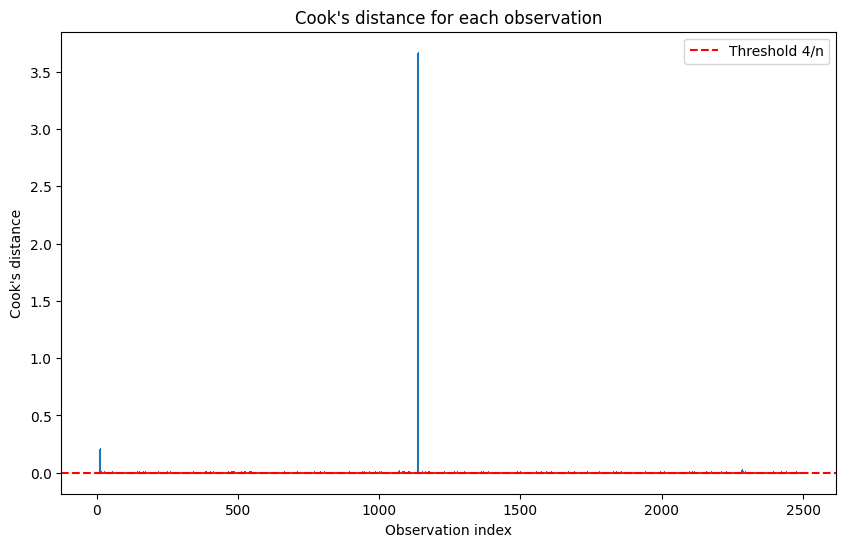

In [11]:
# Cook's distances
influence = model_final_clean.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(X_final_clean)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=4/n, color='r', linestyle='--', label='Threshold 4/n')
plt.title("Cook's distance for each observation")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.legend()
plt.show()


In [12]:
# Identify the most influential observation
idx_culprit = np.argmax(cooks_d)
print(f"The problematic observation is at index: {idx_culprit}")

# Indices of highly influential points to remove
indices_to_remove = [1237, 15]

# Remove hyper-influential points
X_final_no_outlier = X_final_clean.drop(index=indices_to_remove, errors='ignore')
y_train_no_outlier = y_train.drop(index=indices_to_remove, errors='ignore')

# Refit the model without the outliers
model_final_final = sm.OLS(y_train_no_outlier, X_final_no_outlier).fit()

# Compare R-squared before and after
print(f"R-squared before: {model_final_clean.rsquared:.4f}")
print(f"R-squared after: {model_final_final.rsquared:.4f}")

# Display the final model summary
print(model_final_final.summary())


The problematic observation is at index: 1137
R-squared before: 0.8369
R-squared after: 0.8370
                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.837
Model:                             OLS   Adj. R-squared:                  0.836
Method:                  Least Squares   F-statistic:                     705.4
Date:                 Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                         23:37:36   Log-Likelihood:                -5519.3
No. Observations:                 2492   AIC:                         1.108e+04
Df Residuals:                     2473   BIC:                         1.119e+04
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------

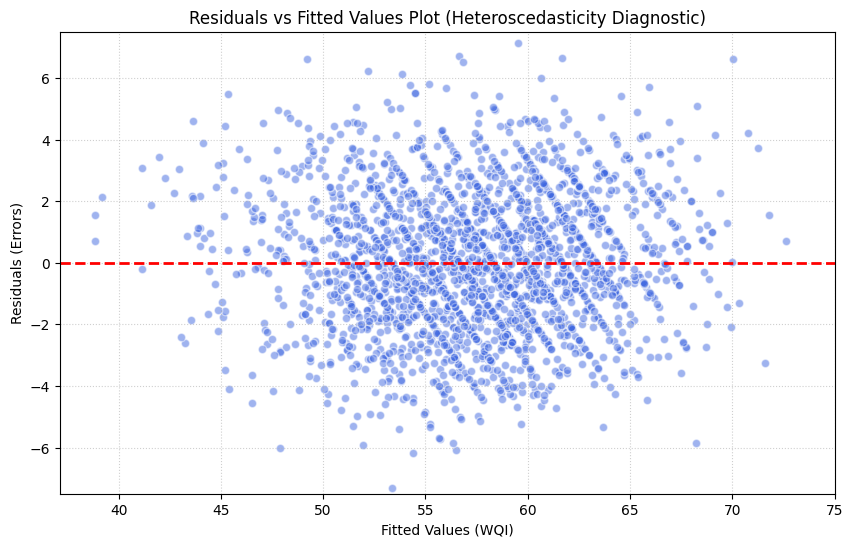

In [20]:
residuals = model_final_final.resid
fitted_values = model_final_final.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5, color='royalblue', edgecolors='white')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.ylim(-7.5, 7.5)

plt.title("Residuals vs Fitted Values Plot (Heteroscedasticity Diagnostic)")
plt.xlabel("Fitted Values (WQI)")
plt.ylabel("Residuals (Errors)")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()



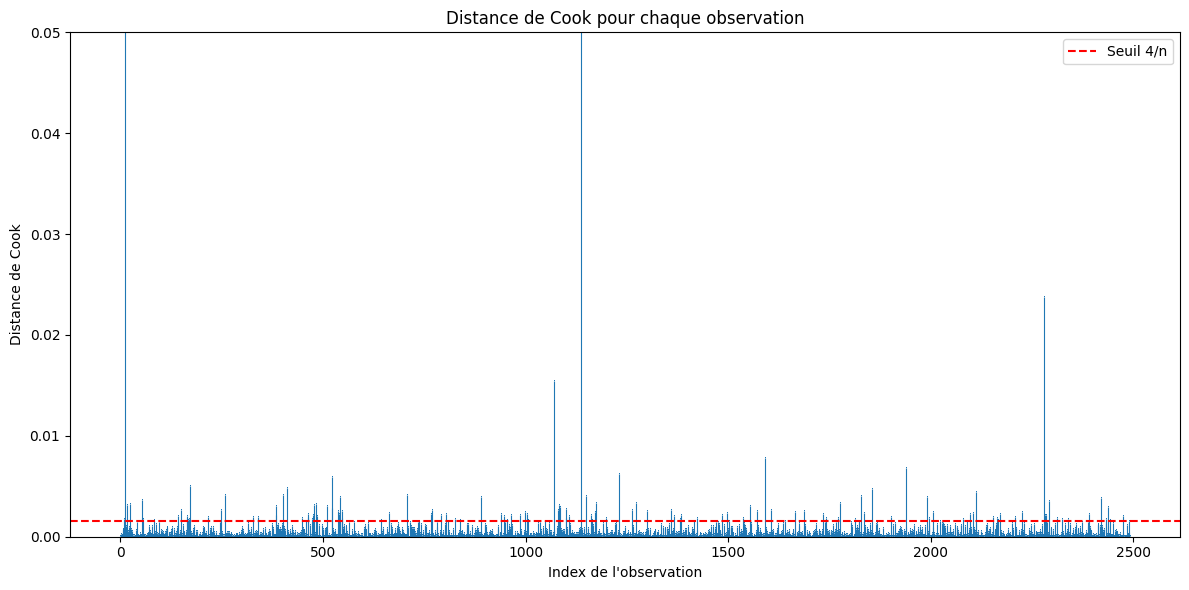

In [14]:
influence = model_final_final.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(X_final_no_outlier)

threshold = 4 / n
idx = np.arange(len(cooks_d))

plt.figure(figsize=(12, 6))

markerline, stemlines, baseline = plt.stem(
    idx,
    cooks_d,
    linefmt='C0-',
    markerfmt=',',
    basefmt=' '
)

plt.setp(stemlines, linewidth=0.8)

plt.axhline(
    y=threshold,
    color='r',
    linestyle='--',
    label='Seuil 4/n'
)

plt.ylim(0, 0.05)

plt.title("Distance de Cook pour chaque observation")
plt.xlabel("Index de l'observation")
plt.ylabel("Distance de Cook")
plt.legend()
plt.tight_layout()
plt.show()



In [15]:
# Prepare validation/prediction dataset
X_val_final = X_final_no_outlier.drop(columns=vars_to_drop_final, errors='ignore')
X_val_final = sm.add_constant(X_val_final)

# Make predictions with the final model
y_pred_final = model_final_final.predict(X_val_final)

# Compute MSPE
mspe_final = mean_squared_error(y_train_no_outlier, y_pred_final)

print(f"MSPE of the final (cleaned) model: {mspe_final:.4f}")


MSPE of the final (cleaned) model: 4.9124


## Test of a linear combination with 2 coefficients


In [16]:
# H0: The effect of Lead is equal to that of Cadmium
test_q6 = model_final_final.t_test("Heavy_Metals_Pb_ug_L = Heavy_Metals_Cd_ug_L")
print(test_q6)


                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.6658      0.227     29.358      0.000       6.221       7.111


## Test of a subset of coefficients equal to zero


In [17]:
# Joint test of coefficients related to Season
# H0: βSpring = βSummer = βWinter = 0 (Autumn = reference category)
# H1: at least one seasonal coefficient is non-zero

vars_season = [v for v in model_final_final.params.index if "Season" in v]

if vars_season:
    hypothesis = " = 0, ".join(vars_season) + " = 0"
    f_test = model_final_final.f_test(hypothesis)

    print(f"F-statistic: {f_test.fvalue:.4f}")
    print(f"P-value: {f_test.pvalue:.4f}")

    if f_test.pvalue < 0.05:
        print("Conclusion: Reject H0. At least one seasonal coefficient is non-zero (reference: Autumn).")
    else:
        print("Conclusion: Do not reject H0. Seasons have no significant effect once other variables are controlled (reference: Autumn).")

else:
    season_cols = [c for c in X_train.columns if "Season" in c] if 'X_train' in globals() else []

    if not season_cols:
        print("Cannot add Season variables.")
    else:
        print("Adding Season dummies (reference: Autumn).")

        X_aug = X_final_no_outlier.copy()
        for col in season_cols:
            if col in X_train.columns:
                X_aug[col] = X_train.loc[y_train_no_outlier.index, col]
            else:
                X_aug[col] = 0

        X_aug = sm.add_constant(X_aug, has_constant='skip')
        model_aug = sm.OLS(y_train_no_outlier, X_aug).fit()

        hypotheses = [f"{c} = 0" for c in season_cols if c in model_aug.params.index]

        if not hypotheses:
            print("Error: Season dummies were not correctly added.")
        else:
            hypothesis = ", ".join(hypotheses)
            f_test = model_aug.f_test(hypothesis)

            print(f"F-statistic (augmented model): {f_test.fvalue:.4f}")
            print(f"P-value: {f_test.pvalue:.4f}")

            if f_test.pvalue < 0.05:
                print("Conclusion: Reject H0. At least one seasonal coefficient is non-zero (reference: Autumn).")
            else:
                print("Conclusion: Do not reject H0. Seasons have no significant effect (reference: Autumn).")


Adding Season dummies (reference: Autumn).
F-statistic (augmented model): 2.4680
P-value: 0.0603
Conclusion: Do not reject H0. Seasons have no significant effect (reference: Autumn).


## Prediction intervals for the validation data
Calculate prediction intervals for the validation data. Does the cover
age percentage of these intervals correspond to the nominal level? If
 not, what could be a reason?

In [18]:
# 1. Feature Engineering on the VALIDATION set (same as training)
X_val = val_df.copy()

# Create squared terms and dummies
X_val['pH_squared'] = X_val['pH'] ** 2
X_val['Turbidity_squared'] = X_val['Turbidity_NTU'] ** 2
X_val = pd.get_dummies(X_val, columns=['Region', 'Season'], drop_first=True, dtype=int)

# 2. Centering (IMPORTANT: use mean_pH and mean_Turb computed on the TRAIN set in cell 9)
X_val['pH_centered'] = X_val['pH'] - mean_pH
X_val['pH_sq_centered'] = X_val['pH_centered'] ** 2
X_val['Turb_centered'] = X_val['Turbidity_NTU'] - mean_Turb
X_val['Turb_sq_centered'] = X_val['Turb_centered'] ** 2

# 3. Align columns with the final model
# Keep only the columns present in the final model (excluding constant which is added later)
cols_model = model_final_final.params.index.drop('const')

# If a model column is missing in validation (e.g., a region absent in test set), add it with zeros
for col in cols_model:
    if col not in X_val.columns:
        X_val[col] = 0

X_val = X_val[cols_model]  # Order columns like training set
X_val = sm.add_constant(X_val)  # Add constant

# 4. Predictions and intervals
predictions = model_final_final.get_prediction(X_val)
pred_frame = predictions.summary_frame(alpha=0.05)  # alpha=0.05 for 95% confidence

# 5. Coverage calculation
y_true = val_df['Water_Quality_Index']
is_covered = (y_true >= pred_frame['obs_ci_lower']) & (y_true <= pred_frame['obs_ci_upper'])
coverage = is_covered.mean() * 100

print(f"Prediction interval coverage (95% nominal): {coverage:.2f}%")

# RMSE for reference
rmse_val = np.sqrt(mean_squared_error(y_true, pred_frame['mean']))
print(f"Validation RMSE: {rmse_val:.4f}")


Prediction interval coverage (95% nominal): 94.33%
Validation RMSE: 2.2153
